In [ ]:
import torch
import torchvision
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

: 

In [2]:
torchvision.__version__

'0.12.0'

In [3]:
data = torchvision.datasets.Sintel(".")

In [4]:
class TSintel(torchvision.datasets.Sintel):
    def __init__(self, root):
        super().__init__(root=root)
        
    def __getitem__(self, index):
        img1, img2, flow = super().__getitem__(index)
        img1 = torchvision.transforms.ToTensor()(img1)
        img2 = torchvision.transforms.ToTensor()(img2)
        return img1, img2, flow

In [5]:
Tdata = TSintel(".")

In [6]:
train_size = round(len(Tdata) * 0.8)
test_size = round(len(Tdata) * 0.2)

In [9]:
assert train_size + test_size == len(Tdata)

In [10]:
train_data, test_data = torch.utils.data.random_split(Tdata, [train_size, test_size], generator=torch.Generator().manual_seed(42))

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [12]:
epochs = 10
lr = 1e-3

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [14]:
device

device(type='cuda')

In [15]:
from model import FlowNetS
from multiscaleloss import multiscaleEPE

/home/ubuntu/cs231n/util.py:11: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  warnings.warn("failed to load custom correlation module"


In [16]:
model = FlowNetS()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)

In [22]:
losses = []

for epoch in range(epochs):
    
    print("Epoch", str(epoch) + ": ", end="")
    epoch_loss = 0.0
    
    for i, (img1, img2, label) in tqdm(enumerate(train_loader)):
        image = torch.cat((img1, img2), dim=1)
        image = image.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        outputs = model(image)
        h, w = label.size()[-2:]
        outputs = [torch.nn.functional.interpolate(outputs[0], (h,w)), *outputs[1:]]
        
        loss = multiscaleEPE(outputs, label, sparse=True)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    print("Loss:", epoch_loss)
    losses.append(epoch_loss)

Epoch 0: 

27it [01:39,  3.68s/it]


Loss: 794115.6220703125
Epoch 1: 

13it [00:54,  4.18s/it]


KeyboardInterrupt: 

In [81]:
i = 160
output = model(torch.cat((Tdata[i][0], Tdata[i][1]), dim=0).unsqueeze(dim=0).to(device))
img_size = Tdata[i][0].shape[1:]
output = torch.nn.functional.interpolate(output, size=img_size, mode="bilinear", align_corners=False).squeeze()

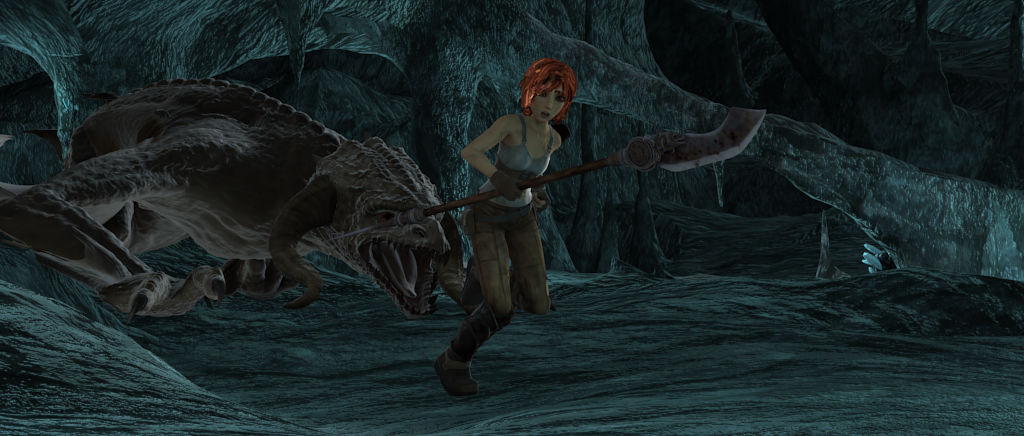

In [82]:
data[i][0]

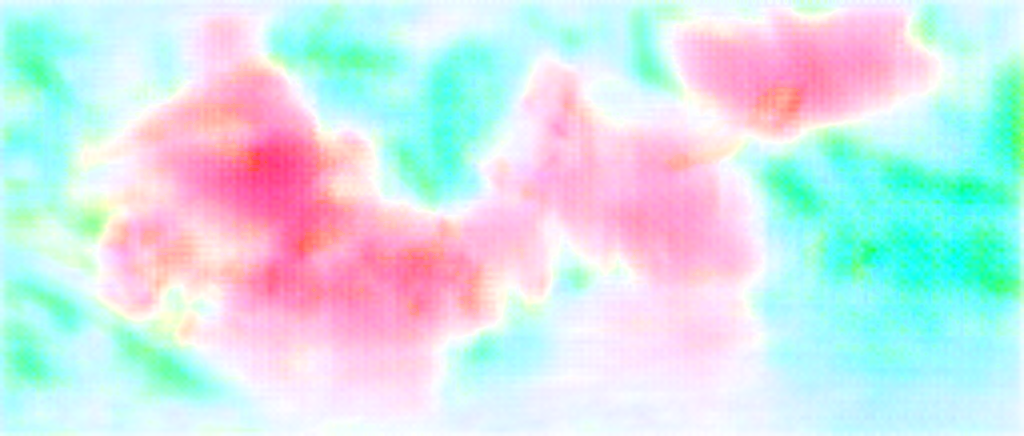

In [83]:
torchvision.transforms.ToPILImage()(torchvision.utils.flow_to_image(output))